## Analysis for cavity resonance

- Evaluate the free spectral range $\delta \nu_{FSR}$ and cavity perimeter $P$

To do this, we:
- converted from time axis to frequency axis, since plot was given in time axis
  - did this by using modulation frequency $\Omega = $10 MHz and finding the times corresponding to where the sidebands are
- FSR is found by the difference in the peaks
- cavity perimeter found by formula $\nu_{FSR} = c / P$
- error analysis done by eyeballing the FWHM of the peaks
- comparison with actual cavity perimeter


To dos:
- can find the error for modulation time search (a lot of work, so most likely skip)
- 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

figure_path = os.path.join(os.getcwd(), "figures")

# import data
data_path = os.path.join(os.getcwd(), "laser_gyroscope_data", "setup")


Evaluating free spectral range and cavity perimeter

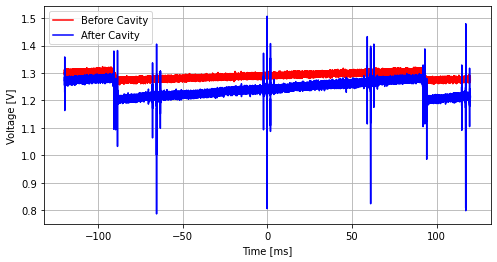

In [2]:
threeres_data = np.genfromtxt(os.path.join(data_path, "3RES.CSV"), delimiter=",", skip_header=1)

time = threeres_data[:,0] * 1e3
input_data = threeres_data[:,1]
res_data = threeres_data[:,2]

# plot back what we saw before
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(time, input_data, color="r", label="Before Cavity")
ax.plot(time, res_data, color="b", label="After Cavity")
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Voltage [V]")
ax.grid()
ax.legend()

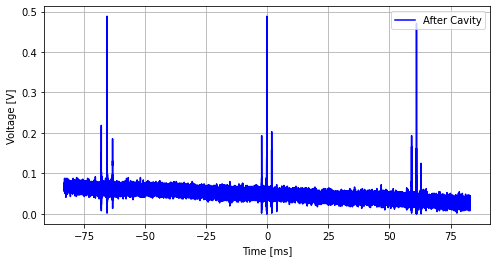

In [3]:
# truncate region to that where the three resonant bands live
time = threeres_data[:,0][20000:-20000]
input_data = threeres_data[:,1][20000:-20000] 
res_data = threeres_data[:,2][20000:-20000]

# subtract from the input laser signal so that the resonance plot is near zero
# then take absolute value so that we see the peaks and no troughs
# this allows easier finding of the sidebands
abs_res = np.abs(res_data - input_data)

# plot back what we saw before
fig, ax = plt.subplots(figsize=(8,4))
# ax.plot(time * 1e3, input_data, color="r", label="Before Cavity")
ax.plot(time * 1e3, abs_res, color="b", label="After Cavity")
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Voltage [V]")
ax.grid()
ax.legend()

sampling rate is : 0.5411255411259103 MHz
sideband peak:  0.21875
Sideband index: 8177
sideband peak:  0.1855500000000001
Sideband index: 10673
sideband peak:  0.19335999999999998
Sideband index: 43688
sideband peak:  0.20313000000000003
Sideband index: 45914
sideband peak:  0.19335999999999998
Sideband index: 76893
sideband peak:  0.125
Sideband index: 79002


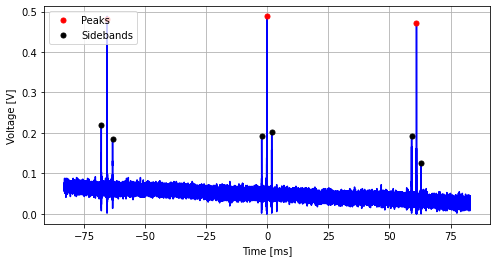

In [25]:
# find where peaks are, then find locations of sidebands since we know that they are 10MHz
peaks_idces_approx = np.argwhere(abs_res > 0.47)  # based from plot'
# print(peaks_idces_approx)
# print(abs_res[9466], abs_res[9468], abs_res[44837])

# from printing and checking, the max indices are
# 9468, 44830, 77974
peaks_idces = [9468, 44830, 77974]

# next find where the sidebands are

# # find sampling rate based on dt
dt = np.abs(time[1] - time[0])
# dfreq = 1 / dt
# print("sampling rate is : {0} MHz".format(dfreq * 1e-6))

peak_regions_idces = [(0, 9000),(10000, 20000), (20000, 44000), (45000, 60000), (60000, 77000), (78000,  len(abs_res))]
sb_indces = np.zeros(6, dtype=int)
# look for them for each region above / below the peak values
# this corr to 6 regions
for i, peak_region_idces in enumerate(peak_regions_idces):
    # cut the frequency range to those where only one sidereal band is contained
    abs_res_cut = abs_res[peak_region_idces[0]:peak_region_idces[1]]


    # look at this region based on looking at plot
    sb_idces_approx = np.argwhere((abs_res_cut > 0.12) & (abs_res_cut < 0.23))
    sb_idces_approx = [int(sb_idces_approx[i]) for i in range(len(sb_idces_approx))] # convert each element to int for indexing
    # print(sidebands_idces_approx)

    # get maximal value from evaluated sidebands
    sb_peak = np.max(abs_res_cut[sb_idces_approx])
    print("sideband peak: ", sb_peak)

    # now we can find the index corr to the sidebands in the original array
    # look at neighbourhood around sideband based on dt
    sb_peak_idces = np.argwhere((abs_res > sb_peak - 2*dt) & (abs_res < sb_peak + 2*dt) )
    # print(sb_peak_idces)

    # further dont look at points that we havent looked at already
    for sb_peak_idx_i in sb_peak_idces:
        # if the determined index value is greater than all values that we already found for
        # this then ignores index values that have already been found
        if np.all(sb_indces < sb_peak_idx_i):
            sb_peak_idx = sb_peak_idx_i[0]
            break  # break allows index values that are greater than the desired one to not be considered

    print("Sideband index: {0}".format(sb_peak_idx))
    
    # store it
    sb_indces[i] = sb_peak_idx

# print(sideband_indces)

# to check, plot the peak points and the 
# plot back what we saw before
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(time * 1e3, abs_res, color="b")
ax.plot(time[peaks_idces]*1e3, abs_res[peaks_idces], marker="o", color="r", linestyle="", ms=5.0, label="Peaks")
ax.plot(time[sb_indces]*1e3, abs_res[sb_indces], marker="o", color="k", linestyle="", ms=5.0, label="Sidebands")
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Voltage [V]")
ax.grid()
ax.legend()

In [17]:
# now find time difference between peak and sidebands
# then find conversion rate to convert time axis to frequency axis based on modulation frequency 10MHz

modulation_time = np.zeros(6)

for i, peak_idx in enumerate(peaks_idces):
    modulation_time[int(2*i)] = np.abs(time[peak_idx] - time[int(sb_indces[int(2*i)])])
    modulation_time[int(2*i + 1)] = np.abs(time[int(sb_indces[int(2*i + 1)])] - time[peak_idx])

# print(modulation_time)

# take average of modulation time, then this would be the conversion rate between frequency and time
mod_time = np.mean(modulation_time)
print("Mean Modulation Time: {0} s".format(mod_time))
    

Mean Modulation Time: 0.0021039479999999974 s


No handles with labels found to put in legend.


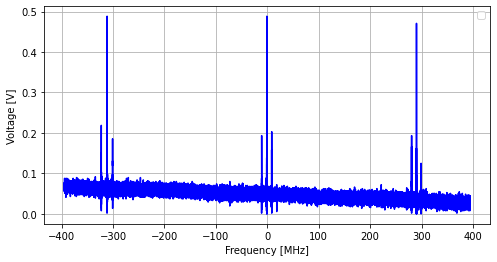

In [32]:
# finally convert time axis to frequency axis

# redefine things again just for safety
time = threeres_data[:,0][20000:-20000]
input_data = threeres_data[:,1][20000:-20000] 
res_data = threeres_data[:,2][20000:-20000]

# subtract from the input laser signal so that the resonance plot is near zero
# then take absolute value so that we see the peaks and no troughs
# this allows easier finding of the sidebands
abs_res = np.abs(res_data - input_data)

# conversion to frequency axis
mod_freq = 10e6  # 10 MHz
freq = time * mod_freq / mod_time

# plot back what we saw before
fig, ax = plt.subplots(figsize=(8,4))
# ax.plot(time * 1e3, input_data, color="r", label="Before Cavity")
ax.plot(freq * 1e-6, abs_res, color="b")
ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Voltage [V]")
ax.grid()
ax.legend()

No handles with labels found to put in legend.


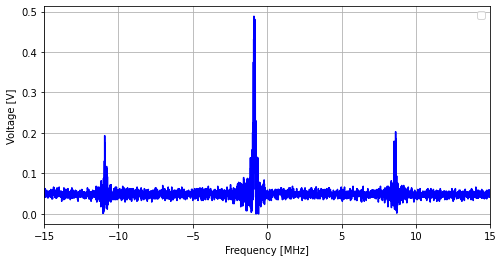

In [27]:
# plot for a single resonance just for clarity 
# plot back what we saw before
fig, ax = plt.subplots(figsize=(8,4))
# ax.plot(time * 1e3, input_data, color="r", label="Before Cavity")
ax.plot(freq * 1e-6, abs_res, color="b")
ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Voltage [V]")
ax.set_xlim([-15, 15])
ax.grid()
ax.legend()

# from this we can clearly see that the modulation frequency has been converted correctly.
# i.e. distance between peak and sidebands are ~ 10MHz

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


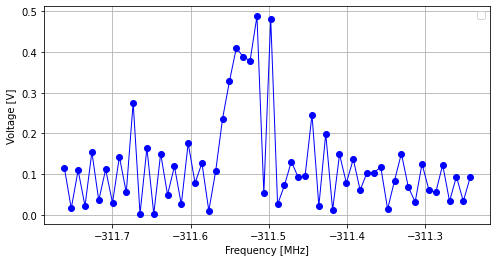

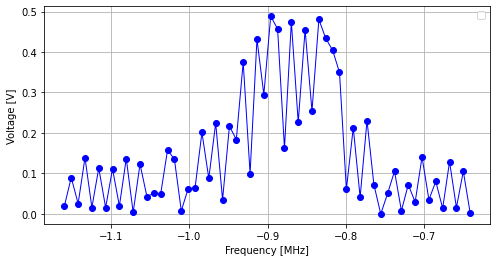

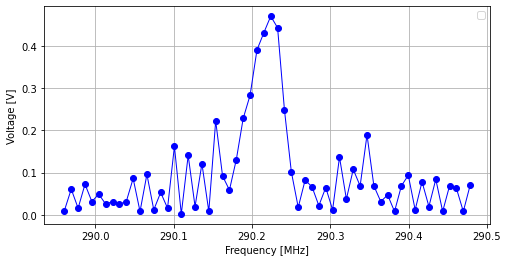

In [41]:
# error analysis
# determine the FWHM of each peak
shift_val = 30

for i, peak_idx in enumerate(peaks_idces):
    # we can do this by eye from plotting each peak
    # should be formally done if we have the time
    fig, ax = plt.subplots(figsize=(8,4))
    # ax.plot(time * 1e3, input_data, color="r", label="Before Cavity")
    ax.plot(freq[peak_idx-shift_val: peak_idx+shift_val] * 1e-6, abs_res[peak_idx-shift_val: peak_idx+shift_val], 
            color="b", marker="o", lw=1.0)
    ax.set_xlabel("Frequency [MHz]")
    ax.set_ylabel("Voltage [V]")
    # ax.set_xlim([-15, 15])
    ax.grid()
    ax.legend()

    # first peak FWHM ~ 0.075 MHz
    # second peak FWHM ~ 0.1 MHz
    # third peak FWHM ~ 0.05 MHz

fwhms = [0.075e6, 0.1e6, 0.05e6]  # in Hz

In [52]:
# find the free spectral range
# i.e. difference between the peaks

# since we already know the peak indices, just need to subtract the freq values corr to such indces
# do this for both peaks, then take average

fsrs = np.zeros(2)
fsr_errs = np.zeros(2)

for i in range(2):
    fsr = freq[peaks_idces[i+1]] - freq[peaks_idces[i]]
    fsr_err = np.sqrt(fwhms[i+1]**2. + fwhms[i]**2.)

    print("FSR for peak {0}-{1}: {2} +- {3} MHz".format(i, i+1, fsr*1e-6, fsr_err*1e-6))

    fsrs[i] = fsr
    fsr_errs[i] = fsr_err

fsr_avg = np.mean(fsrs)
fsr_avg_err = np.sqrt(0.5 * np.sum(fsr_errs**2.))

print("Mean FSR: {0} +- {1} MHz".format(fsr_avg * 1e-6, fsr_avg_err*1e-6))


FSR for peak 0-1: 310.6016688625388 +- 0.125 MHz
FSR for peak 1-2: 291.11989459815584 +- 0.11180339887498947 MHz
Mean FSR: 300.8607817303473 +- 0.11858541225631422 MHz


In [53]:
# find cavity perimeter
c = 3e8  # m/s

peris = c / fsrs
peri_errs = peris / fsrs * fsr_errs

for i in range(2):
    print("Cavity Perimiter for peak {0}-{1}: {2} +- {3} m".format(i, i+1, peris[i], peri_errs[i]))

peris_avg = np.mean(peris)
peris_avg_err = np.sqrt(0.5 * np.sum(peri_errs**2.))

print("Mean Perimeter: {0} +- {1} m".format(peris_avg, peris_avg_err))

Cavity Perimiter for peak 0-1: 0.965867315197103 +- 0.0003887081960691917 m
Cavity Perimiter for peak 1-2: 1.030503258508326 +- 0.0003957605405567243 m
Mean Perimeter: 0.9981852868527146 +- 0.00039225021807075885 m


In [54]:
# compare with the theoretical cavity perimeter

# measured value
peri_thr = 0.990  # m
peri_thr_err = 0.005

# to do this, find the standard error first
peris_avg_std_err = peris_avg_err / np.sqrt(2)

# print test statistic
t = np.abs(peri_thr - peris_avg) / np.sqrt(peris_avg_std_err**2. + peri_thr_err**2.)

print("Obtained Perimeter is {0} sigma values away from measured ones".format(t))


Obtained Perimeter is 1.6345443884839548 sigma values away from measured ones
